# Introduction - Map-to-Image Change Detection

Change detection is a *hot* topic within the Earth Observation (EO) community, particular since the release of the landsat archive and more recently the availablity of the  ESA Sentinel-1 and 2 data.

There are several approaches to change detection and these can be categorised as:

- Map-to-Map
- Image-to-Image
- Map-to-Image
- Dense Timeseries

These approaches have different advances and disadvantages and this tutorial will demonstrate the implementation of a method for each type.

## What is Map-to-Image Change?

Probably the least explored method, here an existing classification at the first date is required but rather than undertaking a second independent classification a methods which compares the image and map to identify the change pixels and then classifies them to update the existing map. These methods **have few assumptions** but generally **expect the area of change to be small** compared to the not changed regions. When a change occurs there is also an **assumption that the change causes the EO signal (reflectance, backscatter etc.) to change being identifiable when compared to the original class**. 

## What are the steps:

Again, this is quite simple. We need a classification and new input image from a different date and we will try to use that input image to find the changes between the two dates.

# 1. Define Imports

In [1]:
%matplotlib inline

import os
import shutil

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib
import rsgislib.changedetect.pxloutlierchng
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
import rsgislib.imageutils
import rsgislib.rastergis
import rsgislib.tools.mapping

# 2. Define Input Images and Directories

In [2]:
cls_2018_dir = "2018_cls"
if not os.path.exists(cls_2018_dir):
    os.mkdir(cls_2018_dir)

cls_1997_dir = "baseline_cls"
if not os.path.exists(cls_1997_dir):
    os.mkdir(cls_1997_dir)

map_to_img_chg_dir = "map_to_img_chg"
if not os.path.exists(map_to_img_chg_dir):
    os.mkdir(map_to_img_chg_dir)


# File path to the 1997 classification
cls_1997_img = os.path.join(cls_1997_dir, "base_1997_class_img.kea")

# File path to the input Landsat 5 image from 1997.
input_97_img = (
    "../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# File path to the Landsat 5 valid data mask from 1997
vld_97_img = os.path.join(cls_1997_dir, "LS5TM_19970716_vmsk.kea")


# File path to the input Landsat 8 image from 2018.
input_18_img = (
    "../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# File path to the Landsat 8 valid data mask from 2018.
vld_18_img = os.path.join(cls_2018_dir, "LS8_20180608_vmsk.kea")

# 3. Calculate NDVI for 2018

In [3]:
ls_2018_ndvi_img = os.path.join(map_to_img_chg_dir, "LS8_20180608_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(input_18_img, 4, 5, ls_2018_ndvi_img)

Image: ../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
	 Variable 'red' is band 4
	 Variable 'nir' is band 5
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.



# 4. Identify Mangrove Change Features

  0%|          | 0/100 [00:00<?, ?it/s]

There were 415619 pixels within the mask.
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'msk' is band 1
Image: map_to_img_chg/LS8_20180608_ndvi.kea
	 Variable 'val' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



0.681421524089254

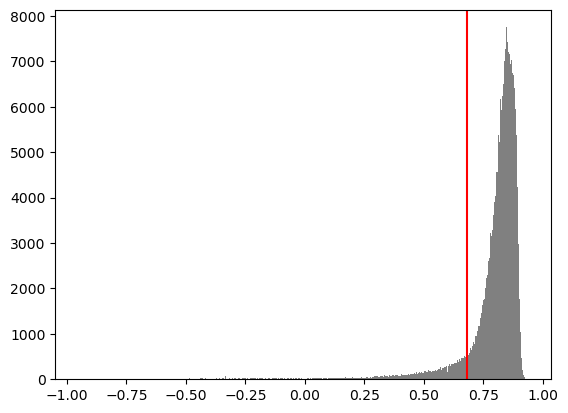

In [4]:
out_mng_chng_msk = os.path.join(map_to_img_chg_dir, "mng_2018_map2img_chngs.kea")
plot_mng_thres_file = os.path.join(
    map_to_img_chg_dir, "mng_2018_map2img_chngs_plot.png"
)

rsgislib.changedetect.pxloutlierchng.find_class_kurt_skew_outliers(
    ls_2018_ndvi_img,
    cls_1997_img,
    out_mng_chng_msk,
    -1,
    1,
    0.35,
    True,
    10.0,
    False,
    img_mask_val=1,  # Specify mangrove class
    img_band=1,
    gdalformat="KEA",
    plot_thres_file=plot_mng_thres_file,
)

# 5. Identify Water Change Features

  0%|          | 0/100 [00:00<?, ?it/s]

There were 209395 pixels within the mask.
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'msk' is band 1
Image: map_to_img_chg/LS8_20180608_ndvi.kea
	 Variable 'val' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



0.31861042122357824

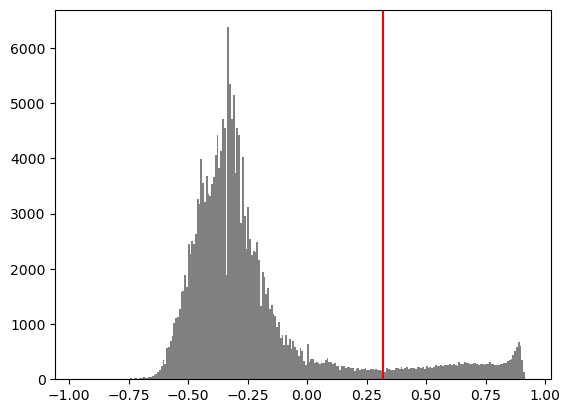

In [5]:
out_water_chng_msk = os.path.join(map_to_img_chg_dir, "water_2018_map2img_chngs.kea")
plot_water_thres_file = os.path.join(
    map_to_img_chg_dir, "water_2018_map2img_chngs_plot.png"
)

rsgislib.changedetect.pxloutlierchng.find_class_kurt_skew_outliers(
    ls_2018_ndvi_img,
    cls_1997_img,
    out_water_chng_msk,
    -1,
    1,
    0.35,
    False,
    10.0,
    False,
    img_mask_val=3,  # Specify water class
    img_band=1,
    gdalformat="KEA",
    plot_thres_file=plot_water_thres_file,
)

# 6. Update 1997 Classification to 2018

In [6]:
chng_2018_cls_img = os.path.join(map_to_img_chg_dir, "chng_map_2018_map2img.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_18_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("mng_chng", out_mng_chng_msk, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("wat_chng", out_water_chng_msk, 1))
exp = """(vld_18_msk==1)&&(cls_1997==1)&&(mng_chng==2)?3:
         (vld_18_msk==1)&&(cls_1997==3)&&(wat_chng==2)?1:
         cls_1997
      """
rsgislib.imagecalc.band_math(
    chng_2018_cls_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)
rsgislib.rastergis.pop_rat_img_stats(
    chng_2018_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: map_to_img_chg/mng_2018_map2img_chngs.kea
	 Variable 'mng_chng' is band 1
Image: map_to_img_chg/water_2018_map2img_chngs.kea
	 Variable 'wat_chng' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 7. Create Change Image

In [7]:
# Define output image path
chng_map_img = os.path.join(map_to_img_chg_dir, "chng_map_1997_2018_map2img.kea")

# Define the input image bands
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_2018", chng_2018_cls_img, 1))

# Expression to define change classes
exp = """(cls_1997==1)&&(cls_2018==1)?11:
         (cls_1997==1)&&(cls_2018==2)?12:
         (cls_1997==1)&&(cls_2018==3)?13:
         (cls_1997==2)&&(cls_2018==1)?21:
         (cls_1997==2)&&(cls_2018==2)?22:
         (cls_1997==2)&&(cls_2018==3)?23:
         (cls_1997==3)&&(cls_2018==1)?31:
         (cls_1997==3)&&(cls_2018==2)?32:
         (cls_1997==3)&&(cls_2018==3)?33:0
      """

# Run band_math
rsgislib.imagecalc.band_math(chng_map_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns)

# Populate stats and pyramids
rsgislib.rastergis.pop_rat_img_stats(
    chng_map_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: map_to_img_chg/chng_map_2018_map2img.kea
	 Variable 'cls_2018' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



# 8. Colour and Name Change Classes

In [8]:
class_info_dict = dict()
class_info_dict[11] = {
    "classname": "Mangrove_Mangrove",
    "red": 25,
    "green": 200,
    "blue": 25,
}
class_info_dict[12] = {
    "classname": "Mangrove_Terrestrial",
    "red": 200,
    "green": 100,
    "blue": 25,
}
class_info_dict[13] = {
    "classname": "Mangrove_Water",
    "red": 200,
    "green": 25,
    "blue": 200,
}
class_info_dict[21] = {
    "classname": "Terrestrial_Mangrove",
    "red": 125,
    "green": 100,
    "blue": 125,
}
class_info_dict[22] = {
    "classname": "Terrestrial_Terrestrial",
    "red": 125,
    "green": 125,
    "blue": 125,
}
class_info_dict[23] = {
    "classname": "Terrestrial_Water",
    "red": 125,
    "green": 125,
    "blue": 100,
}
class_info_dict[31] = {
    "classname": "Water_Mangrove",
    "red": 25,
    "green": 255,
    "blue": 200,
}
class_info_dict[32] = {
    "classname": "Water_Terrestrial",
    "red": 62,
    "green": 62,
    "blue": 200,
}
class_info_dict[33] = {"classname": "Water_Water", "red": 25, "green": 25, "blue": 200}

rsgislib.rastergis.set_class_names_colours(chng_map_img, "class_names", class_info_dict)

# 9. Visual Change Result

Image Data Size: 900 x 767


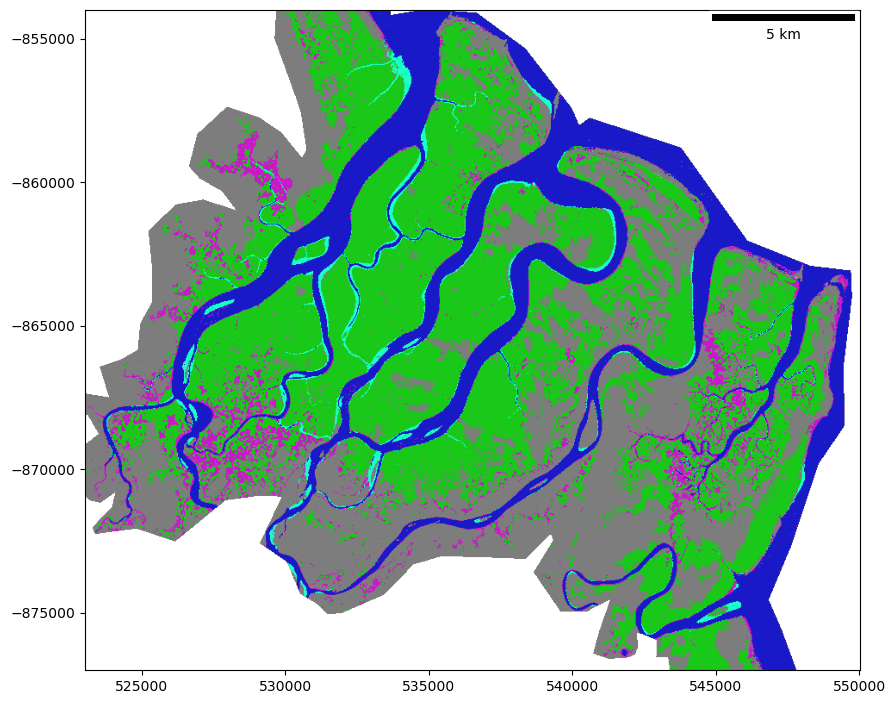

In [9]:
sub_bbox = [523000, 550000, -877000, -854000]

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the change result
rsgislib.tools.mapping.create_thematic_raster_map(ax, chng_map_img, bbox=sub_bbox)